In [1]:
import numpy as np
import pandas as pd

# Evaludate CI On Trained Survival Model

In [2]:
data = pd.read_csv("/home/pzs2/capstone/proj/risk/visualization/TCGA/data/genentech_processed.tsv", sep="\t")
clinical = pd.read_csv("./data/genentech_processed.labels.tsv", sep="\t")

In [3]:
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

def negative_log_partial_likelihood(censor, risk):
    """Return the negative log-partial likelihood of the prediction
    y_true contains the survival time
    risk is the risk output from the neural network
    censor is the vector of inputs that are censored
    regularization is the regularization constant (not used currently in model)

    Uses the Keras backend to perform calculations

    Sorts the surv_time by sorted reverse time
    """

    # calculate negative log likelihood from estimated risk
    epsilon = 0.001
    risk = K.reshape(risk, [-1])  # flatten
    hazard_ratio = K.exp(risk)

    # cumsum on sorted surv time accounts for concordance
    log_risk = K.log(tf.cumsum(hazard_ratio)+epsilon)
    log_risk = K.reshape(log_risk, [-1])
    uncensored_likelihood = risk - log_risk

    # apply censor mask: 1 - dead, 0 - censor
    censored_likelihood = uncensored_likelihood * censor
    num_observed_events = K.sum(censor)
    neg_likelihood = - K.sum(censored_likelihood) / \
        tf.cast(num_observed_events, tf.float32)

    return neg_likelihood

Using TensorFlow backend.


In [4]:
from lifelines.utils import concordance_index

def concordance_metric(survival_time, predicted_risk, censor):
    # calculate the concordance index
    epsilon = 0.001
    partial_hazard = np.exp(-(predicted_risk+epsilon)).flatten()
    censor = censor.astype(int)
    ci = concordance_index(survival_time, partial_hazard, censor)
    return ci

OS = clinical[['OS']].values.flatten()
event = clinical[['Event']].values.flatten()

In [6]:
files = ["/home/pzs2/capstone/models/surv_immune_xfer_10_28__00_47/surv/checkpoint.0350.hdf5"]

for hdf5 in files:
    surv_model = load_model(hdf5, custom_objects={
                                            'negative_log_partial_likelihood': negative_log_partial_likelihood})
    predictions = surv_model.predict(data)
    ci = concordance_metric(OS, np.exp(predictions), event)
    print("File: {}, CI: {}".format(hdf5, ci))

File: /home/pzs2/capstone/models/surv_immune_xfer_10_28__00_47/surv/checkpoint.0350.hdf5, CI: 0.494954838457


/home/pzs2/keras/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


# Transfer Learning

In [92]:
surv_path = "/home/pzs2/capstone/models/surv_immune_xfer_10_28__20_10/surv/checkpoint.0380.hdf5"
pd_path = "/home/pzs2/capstone/models/surv_immune_xfer_10_28__20_10/immune/genes.hdf5"

In [93]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# read in datasets
data = pd.read_csv("/home/pzs2/capstone/proj/risk/visualization/TCGA/data/genentech_processed.tsv", sep="\t")
clinical = pd.read_csv("./data/genentech_processed.labels.tsv", sep="\t")

# parse out features and labels
labels = clinical[['Event']].values.ravel()
data = data.values

# sample from shuffled dataset
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y)


# Upsample
sm = SMOTE(random_state=12, ratio = 1.0)
x_train, y_train = sm.fit_sample(x_train, y_train)
x_val, y_val = sm.fit_sample(x_val, y_val)

def shuffle(X, y):
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    X = X[shuffle_indices,:]
    y = y[shuffle_indices]
    return X,y

x_train, y_train = shuffle(x_train, y_train)
x_val, y_val = shuffle(x_val, y_val)

# Turn labels into categorical values
y_train_cat = np.append(y_train.reshape([-1,1]), np.abs(y_train - 1).reshape([-1,1]), axis=1)
y_val_cat = np.append(y_val.reshape([-1,1]), np.abs(y_val - 1).reshape([-1,1]), axis=1)

## Model From Scratch

In [156]:
from keras.models import Sequential, Model, load_model
import keras.layers as layers
from keras import regularizers

model = Sequential()
model.add(layers.Dense(128, input_dim=x_train.shape[1],
                       kernel_regularizer=regularizers.l2(0.01),
                       activity_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1, activation='sigmoid'))

opt = Adam(lr=0.005)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'ce'])

model.fit(x_train, y_train,
          batch_size=64,
          epochs=100,
          validation_data=(x_val, y_val))

print("LR: {}, Training: {}, Eval: {}".format(lr, 
                                                  model.evaluate(x=x_train, y=y_train), 
                                                  model.evaluate(x=x_val, y=y_val)))

Train on 290 samples, validate on 74 samples
Epoch 1/100
290/290 [==============================] - 32s 110ms/step - loss: 2096608.5341 - acc: 0.5586 - ce: 0.6740 - val_loss: 1271607.3780 - val_acc: 0.5946 - val_ce: 0.6837
Epoch 2/100
290/290 [==============================] - 0s 415us/step - loss: 973661.2515 - acc: 0.6724 - ce: 0.6316 - val_loss: 731971.9231 - val_acc: 0.5135 - val_ce: 0.7169
Epoch 3/100
290/290 [==============================] - 0s 429us/step - loss: 651495.4081 - acc: 0.6724 - ce: 0.5973 - val_loss: 444325.7033 - val_acc: 0.6892 - val_ce: 0.6037
Epoch 4/100
290/290 [==============================] - 0s 430us/step - loss: 393248.4249 - acc: 0.7345 - ce: 0.5363 - val_loss: 362774.3709 - val_acc: 0.5676 - val_ce: 0.7172
Epoch 5/100
290/290 [==============================] - 0s 425us/step - loss: 292173.9898 - acc: 0.7621 - ce: 0.4739 - val_loss: 229689.8331 - val_acc: 0.6486 - val_ce: 0.6298
Epoch 6/100
290/290 [==============================] - 0s 424us/step - loss: 

Epoch 48/100
290/290 [==============================] - 0s 399us/step - loss: 5819.2446 - acc: 0.9931 - ce: 0.0263 - val_loss: 25633.1575 - val_acc: 0.7162 - val_ce: 1.0818
Epoch 49/100
290/290 [==============================] - 0s 403us/step - loss: 5825.8251 - acc: 0.9931 - ce: 0.0367 - val_loss: 26461.4702 - val_acc: 0.6486 - val_ce: 1.2418
Epoch 50/100
290/290 [==============================] - 0s 424us/step - loss: 6002.4022 - acc: 0.9862 - ce: 0.0271 - val_loss: 25947.6742 - val_acc: 0.6757 - val_ce: 1.4677
Epoch 51/100
290/290 [==============================] - 0s 423us/step - loss: 5643.4010 - acc: 0.9966 - ce: 0.0170 - val_loss: 26892.4140 - val_acc: 0.6486 - val_ce: 1.3777
Epoch 52/100
290/290 [==============================] - 0s 436us/step - loss: 6026.0370 - acc: 0.9828 - ce: 0.0512 - val_loss: 27677.2206 - val_acc: 0.6892 - val_ce: 1.5097
Epoch 53/100
290/290 [==============================] - 0s 437us/step - loss: 7197.5757 - acc: 0.9759 - ce: 0.0679 - val_loss: 31045.66

290/290 [==============================] - 0s 430us/step - loss: 2657.2909 - acc: 0.9690 - ce: 0.0742 - val_loss: 18983.6613 - val_acc: 0.7162 - val_ce: 2.2730
Epoch 96/100
290/290 [==============================] - 0s 435us/step - loss: 2470.5072 - acc: 0.9552 - ce: 0.0804 - val_loss: 19168.5995 - val_acc: 0.7162 - val_ce: 2.1254
Epoch 97/100
290/290 [==============================] - 0s 430us/step - loss: 2402.7699 - acc: 0.9862 - ce: 0.0652 - val_loss: 18804.1666 - val_acc: 0.6892 - val_ce: 2.2434
Epoch 98/100
290/290 [==============================] - 0s 428us/step - loss: 2642.4064 - acc: 0.9931 - ce: 0.0337 - val_loss: 19069.9842 - val_acc: 0.7297 - val_ce: 2.4255
Epoch 99/100
290/290 [==============================] - 0s 441us/step - loss: 3084.5306 - acc: 0.9759 - ce: 0.0538 - val_loss: 21066.9698 - val_acc: 0.5405 - val_ce: 4.0757
Epoch 100/100
74/74 [==============================] - 0s 520us/step
LR: 0.0007, Training: [3938.684118652344, 0.7275862068965517, 1.126614404365356

## Just On Survival

In [94]:
import collections
print(collections.Counter(y_train))
print(collections.Counter(y_val))

Counter({0: 145, 1: 145})
Counter({0: 37, 1: 37})


In [143]:
from keras.models import Sequential, Model, load_model
import keras.layers as layers
from keras.optimizers import Adam

surv_model = Sequential()
surv_model = load_model(surv_path, custom_objects={
                                            'negative_log_partial_likelihood': negative_log_partial_likelihood})

# taking out the last layer layers
surv_model.pop()
surv_model.add(layers.Dense(1, activation="sigmoid", name="surv_output"))

# freeze all the layers before the output layer
# for layer in surv_model.layers[0:-2]:
#     layer.trainable = False

opt = Adam(lr=0.005)

surv_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'ce'])

surv_model.fit(x_train, y_train,
          batch_size=64,
          epochs=100,
          validation_data=(x_val, y_val))

Train on 290 samples, validate on 74 samples
Epoch 1/100
290/290 [==============================] - 30s 103ms/step - loss: 800181.9262 - acc: 0.5310 - ce: 0.7206 - val_loss: 506078.2321 - val_acc: 0.5135 - val_ce: 0.7503
Epoch 2/100
290/290 [==============================] - 0s 380us/step - loss: 366975.3267 - acc: 0.5690 - ce: 0.6813 - val_loss: 392947.1464 - val_acc: 0.5000 - val_ce: 0.8246
Epoch 3/100
290/290 [==============================] - 0s 367us/step - loss: 272105.3079 - acc: 0.5793 - ce: 0.6793 - val_loss: 271018.7662 - val_acc: 0.4595 - val_ce: 0.7739
Epoch 4/100
290/290 [==============================] - 0s 378us/step - loss: 202472.5354 - acc: 0.6586 - ce: 0.6307 - val_loss: 159885.5456 - val_acc: 0.4730 - val_ce: 0.7536
Epoch 5/100
290/290 [==============================] - 0s 375us/step - loss: 142154.2123 - acc: 0.6897 - ce: 0.6208 - val_loss: 90040.7507 - val_acc: 0.5541 - val_ce: 0.7931
Epoch 6/100
290/290 [==============================] - 0s 367us/step - loss: 924

290/290 [==============================] - 0s 378us/step - loss: 1803.2629 - acc: 0.9793 - ce: 0.0672 - val_loss: 8992.5839 - val_acc: 0.6622 - val_ce: 1.0807
Epoch 49/100
290/290 [==============================] - 0s 393us/step - loss: 1677.1909 - acc: 0.9828 - ce: 0.0552 - val_loss: 9170.8405 - val_acc: 0.6892 - val_ce: 1.2717
Epoch 50/100
290/290 [==============================] - 0s 362us/step - loss: 1655.3337 - acc: 0.9759 - ce: 0.0612 - val_loss: 8725.9980 - val_acc: 0.7838 - val_ce: 1.0056
Epoch 51/100
290/290 [==============================] - 0s 375us/step - loss: 1511.0176 - acc: 0.9862 - ce: 0.0448 - val_loss: 8552.9655 - val_acc: 0.7027 - val_ce: 1.2947
Epoch 52/100
290/290 [==============================] - 0s 367us/step - loss: 1465.9031 - acc: 0.9828 - ce: 0.0585 - val_loss: 8336.3003 - val_acc: 0.6757 - val_ce: 1.3992
Epoch 53/100
290/290 [==============================] - 0s 378us/step - loss: 1383.9969 - acc: 0.9724 - ce: 0.0594 - val_loss: 8626.0735 - val_acc: 0.689

Epoch 96/100
290/290 [==============================] - 0s 376us/step - loss: 2685.1114 - acc: 0.9483 - ce: 0.2024 - val_loss: 11614.8616 - val_acc: 0.5541 - val_ce: 3.0975
Epoch 97/100
290/290 [==============================] - 0s 381us/step - loss: 4004.3609 - acc: 0.9448 - ce: 0.1544 - val_loss: 10880.7079 - val_acc: 0.6486 - val_ce: 1.6732
Epoch 98/100
290/290 [==============================] - 0s 409us/step - loss: 3405.2287 - acc: 0.9586 - ce: 0.1105 - val_loss: 9264.8108 - val_acc: 0.7297 - val_ce: 1.2419
Epoch 99/100
290/290 [==============================] - 0s 374us/step - loss: 4566.5275 - acc: 0.9552 - ce: 0.1257 - val_loss: 11837.9576 - val_acc: 0.6757 - val_ce: 1.4585
Epoch 100/100
290/290 [==============================] - 0s 366us/step - loss: 4399.2817 - acc: 0.9586 - ce: 0.1342 - val_loss: 11696.5943 - val_acc: 0.7432 - val_ce: 1.1676


In [144]:
surv_model.evaluate(x=x_val, y=y_val)

74/74 [==============================] - 0s 674us/step


[5943.431069863809, 0.7432432448541796, 1.1675961452561456]

# Predicting with PD-1 / PD-L1 Layer

In [137]:
from keras.models import Sequential, Model
import keras.layers as layers
from keras.optimizers import Adam, SGD

# surv_model = Sequential()
# surv_model = load_model(pd_path)
        
lrs = [0.003, 0.002, 0.001, 0.0009, 0.0008, 0.0007]
xfer_models = []

for lr in lrs:
    pd1_model = Sequential()
    pd1_model = load_model(pd_path)
    
    # remove the last layer
    pd1_model.pop()

    # add sigmoid layer for categorical classification
    pd1_model.add(layers.Dense(1, activation="sigmoid", name="xfer_output"))

    # freeze all the layers before the output layer
#     for layer in pd1_model.layers[0:3]:
#         layer.trainable = False
        
    opt = Adam(lr=lr)
    pd1_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy','ce'])

    pd1_model.fit(x_train, 
                y_train,
                batch_size=64,
                epochs=100,
                verbose=0)
    print("LR: {}, Training: {}, Eval: {}".format(lr, 
                                                  pd1_model.evaluate(x=x_train, y=y_train), 
                                                  pd1_model.evaluate(x=x_val, y=y_val)))
    xfer_models.append(pd1_model)

74/74 [==============================] - 0s 383us/step
LR: 0.003, Training: [1801.746461460508, 0.6172413793103448, 2.464968499130216], Eval: [4212.607707255595, 0.5810810794701448, 3.356396449578775]
74/74 [==============================] - 0s 389us/step
LR: 0.002, Training: [603.3025790642048, 0.5724137931034483, 2.948080648857988], Eval: [3011.110888506915, 0.6891891908001255, 2.579863135879104]
74/74 [==============================] - 0s 398us/step
LR: 0.001, Training: [477.40202889278015, 0.903448275862069, 0.25199364698010274], Eval: [3286.899282919394, 0.797297295686361, 1.5704056958894472]
74/74 [==============================] - 0s 364us/step
LR: 0.0009, Training: [554.0246346835432, 0.8931034482758621, 0.3195891743590092], Eval: [3473.1921700142525, 0.7702702718812067, 2.0222114711194425]
74/74 [==============================] - 0s 396us/step
LR: 0.0008, Training: [588.311933517456, 0.9793103448275862, 0.06515364013933415], Eval: [3524.9960096204604, 0.8648648632539285, 0.960

In [130]:
for layer in pd1_model.layers:
    print(layer.name, layer.trainable)
pd1_model.summary()

(u'dense_1', False)
(u'batch_normalization_1', False)
(u'dense_2', False)
(u'batch_normalization_2', False)
(u'dense_3', True)
(u'dense_4', True)
(u'dense_5', True)
(u'dense_6', True)
(u'xfer_dense_output', True)
('xfer_output', True)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               137856    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_______________________________________

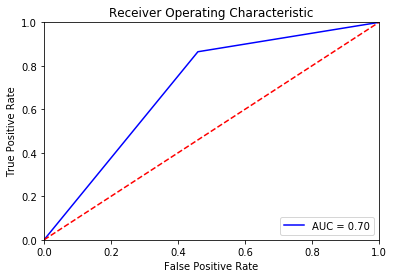

In [157]:
from sklearn.metrics import roc_curve, auc

predicted_events = np.round(model.predict(x_val)).flatten()

fpr, tpr, threshold = roc_curve(y_val, predicted_events)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

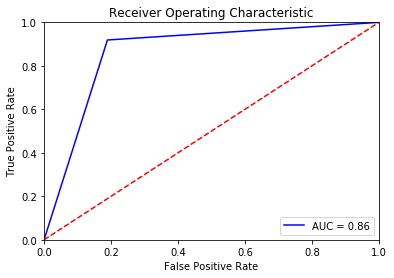

In [145]:
from sklearn.metrics import roc_curve, auc

predicted_events = np.round(xfer_models[-2].predict(x_val)).flatten()

fpr_xfer, tpr_xfer, threshold = roc_curve(y_val, predicted_events)
roc_auc_xfer = auc(fpr_xfer, tpr_xfer)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_xfer, tpr_xfer, 'b', label = 'AUC = %0.2f' % roc_auc_xfer)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

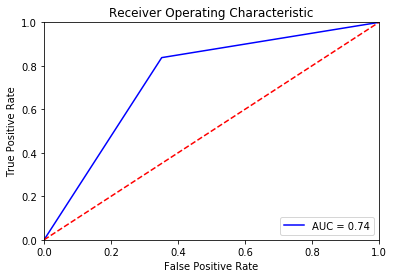

In [146]:
from sklearn.metrics import roc_curve, auc

predicted_events = np.round(surv_model.predict(x_val)).flatten()

fpr_surv, tpr_surv, threshold = roc_curve(y_val, predicted_events)
roc_auc_surv = auc(fpr_surv, tpr_surv)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_surv, tpr_surv, 'b', label = 'AUC = %0.2f' % roc_auc_surv)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

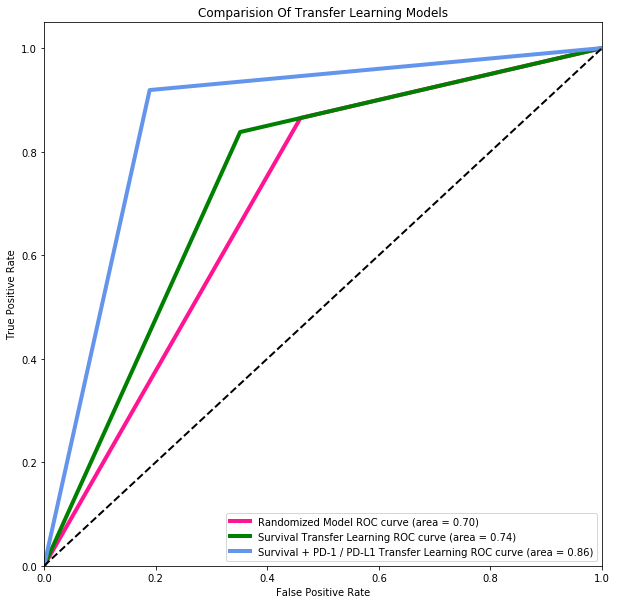

In [158]:
# Plot all ROC curves
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr,
         label='Randomized Model ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='deeppink', linewidth=4)

plt.plot(fpr_surv, tpr_surv,
         label='Survival Transfer Learning ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_surv),
         color='green', linewidth=4)

plt.plot(fpr_xfer, tpr_xfer,
         label='Survival + PD-1 / PD-L1 Transfer Learning ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_xfer),
         color='cornflowerblue', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparision Of Transfer Learning Models')
plt.legend(loc="lower right")
plt.show()

In [159]:
pd1_model.pop()
pd1_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
pd1_model.predict(x_val)[1:5,:]

array([[16.188902  , 13.356269  ,  0.41513726,  3.1575902 , 23.929192  ,
         8.97793   , 21.214195  ,  4.226098  ,  0.        , 14.954628  ,
        10.623936  ,  7.582971  ,  0.        , 26.318346  ,  3.4723864 ,
        17.761963  ,  0.        ,  0.13591264, 12.516293  , 15.657808  ,
         1.4874778 ,  9.362199  ,  0.        , 10.234187  ,  3.2789347 ,
        10.295626  ,  4.6180897 ,  7.3251953 ,  0.        ,  0.        ,
         1.4818314 ,  0.17672338],
       [22.091087  , 18.835344  ,  0.        ,  1.3647884 , 22.908077  ,
        11.345325  , 26.03316   ,  1.3807743 ,  0.        , 11.913835  ,
         8.572492  ,  4.7681823 ,  0.        , 24.390676  ,  5.0957975 ,
        16.37837   ,  0.        ,  7.312107  ,  9.3461075 , 19.77326   ,
         0.        ,  6.397451  ,  0.        ,  8.338259  ,  7.170928  ,
         6.298903  ,  0.8860994 ,  7.1498213 ,  0.        ,  0.        ,
         3.5374463 ,  0.        ],
       [18.185827  , 13.056443  ,  0.        ,  3.7724

# t-SNE Visualization

## Visualizing Survival Layer

In [171]:
cancertypes = pd.read_csv("/home/pzs2/capstone/proj/TCGA_processed/pancancer_all_immune/cancer.type.train.txt").iloc[:,0]
data = pd.read_csv("/home/pzs2/capstone/proj/TCGA_processed/pancancer_all_immune/TrainingData.txt", sep="\t")

cancertypes = cancertypes.astype('category')
cancer_categories = cancertypes.astype('category').cat.categories

In [172]:
import random

def get_random_color(pastel_factor = 0.5):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

colors = []

for i in range(0,len(cancer_categories)):
  colors.append(generate_new_color(colors,pastel_factor = 0.9))

### Unnormalized Model

In [ ]:
from keras.models import Sequential, Model, load_model
import keras.layers as layers

from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.manifold import TSNE

surv_model = Sequential()
surv_model = load_model("/home/pzs2/capstone/models/no_norm_10_27__17_27/surv.hdf5", custom_objects={
                                            'negative_log_partial_likelihood': negative_log_partial_likelihood})

# taking out the last layer layers
surv_model.pop()

predictions_type = surv_model.predict(data)

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=5000) # reduce perplexity?
tsne_results = tsne.fit_transform(predictions_type)

plt.figure(figsize=(12, 12))
for i, c in zip(cancer_categories, colors, ):
    plt.scatter(tsne_results[cancertypes == i, 0], tsne_results[cancertypes == i, 1], c=c, label=i)
plt.legend()
plt.show()

### Normalized Model

In [ ]:
from keras.models import Sequential, Model, load_model
import keras.layers as layers

from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.manifold import TSNE

surv_model = Sequential()
surv_model = load_model("/home/pzs2/capstone/models/surv_immune_xfer_10_27__00_29/surv/checkpoint.0350.hdf5", custom_objects={
                                            'negative_log_partial_likelihood': negative_log_partial_likelihood})

# taking out the last layer layers
surv_model.pop()


predictions_type = surv_model.predict(data)

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=5000)
tsne_results = tsne.fit_transform(predictions_type)

plt.figure(figsize=(12, 12))
for i, c in zip(cancer_categories, colors, ):
    plt.scatter(tsne_results[cancertypes == i, 0], tsne_results[cancertypes == i, 1], c=c, label=i)
plt.legend()
plt.show()

In [165]:
from keras.models import save_model

save_model(model, "model/random.hdf5")
save_model(surv_model, "model/surv_xfer.hdf5")
save_model(xfer_models[-2], "model/pd_xfer.hdf5")

## Visualizing Genentech Survival

In [176]:
data = pd.read_csv("/home/pzs2/capstone/proj/risk/visualization/TCGA/data/genentech_processed.tsv", sep="\t")
clinical = pd.read_csv("./data/genentech_processed.labels.tsv", sep="\t")
event = clinical[['Event']].values.flatten()

In [167]:
xfer_model = xfer_models[-2]

In [168]:
xfer_model.pop()

opt = Adam(lr=3e-5)

xfer_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 348 samples in 0.000s...
[t-SNE] Computed neighbors for 348 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 348 / 348
[t-SNE] Mean sigma: 3.638194
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.452713
[t-SNE] KL divergence after 1700 iterations: 0.637347


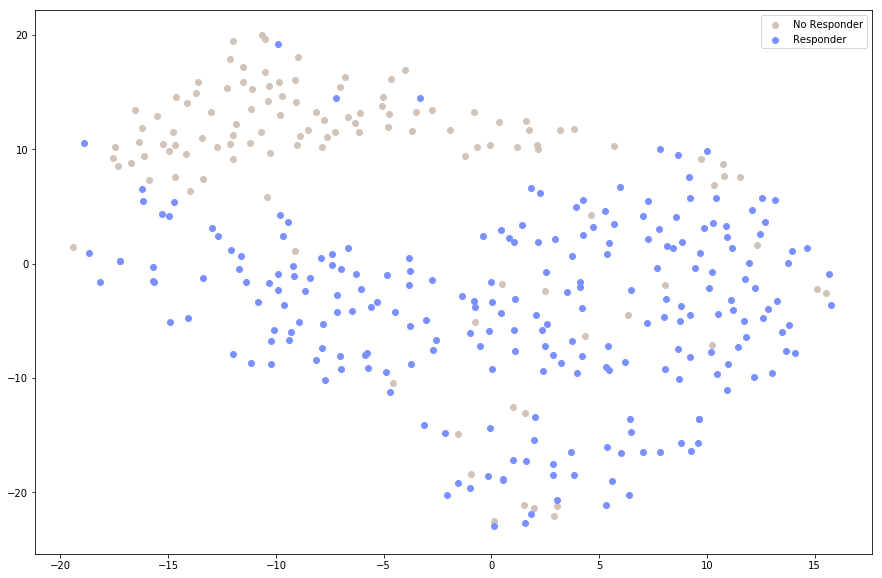

In [179]:
from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.manifold import TSNE

predictions_type = xfer_model.predict(data)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=5000)
tsne_results = tsne.fit_transform(predictions_type)

plt.figure(figsize=(15, 10))
for i, c, l in zip([0,1], colors, ['No Responder', 'Responder']):
    plt.scatter(tsne_results[event == i, 0], tsne_results[event == i, 1], c=c, label=l)
plt.legend()
plt.show()

In [ ]:
predictions_type[1:10,:]

In [ ]:
plt.figure(figsize=(10, 10))
for i, c in zip([0,1], colors):
    plt.scatter(predictions_type[event == i, 0], predictions_type[event == i, 1], c=c, label=i)
plt.legend()
plt.show()

In [ ]:
tsne_results2 = tsne_results

In [ ]:
fig = plt.figure(figsize=(20, 16))
# colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c in zip(cancer_categories, colors):
    plt.scatter(tsne_results2[cancertypes == i, 0], tsne_results2[cancertypes == i, 1], c=c, label=i)
plt.legend()
plt.show()
fig.savefig("tsne_cancertypes")

In [ ]:
tsne_results_pd = pd.DataFrame(tsne_results2)
tsne_results_pd.to_csv("tsne_output.csv")